In [1]:
import sys
import pandas as pd
import numpy as np
import math
from scipy.special import softmax
from scipy.optimize import minimize, LinearConstraint
from scipy.spatial.distance import braycurtis
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
from imports import *
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
# # adding Folder_2 to the system path
# sys.path.insert(0, r'C:\Users\tomer\Desktop\BSc\year3\sem B\workshop_microbiome\code')
# # sys.path.insert(0, r'C:\Users\yuvald\Documents\Uni\סמסטר ב\workshop_microbiome\code')

from imports import  *

import social_model_class_v2_cos
reload(social_model_class_v2_cos)
# reload(imports)


<module 'social_model_class_v2_cos' from '/home/jupyter-tomeroron/baboons/social_model_class_v2_cos.py'>

In [2]:
data_path = r"train_data.csv"
metadata_path = r"train_metadata.csv"

$$\Delta_t  \space windowing$$

In [3]:
model = social_model_class_v2_cos.superModel(data_path, metadata_path)

np.all(model.metadata_df.index == model.data_df.index)

/home/jupyter-tomeroron/baboons/social_model_class_v2_cos.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_clean['collection_date'] = pd.to_datetime(metadata_clean['collection_date'])


True

## cross validation (4 - fold)

In [4]:

baboons = model.baboons
dict_list = list(model.baboons.items())
np.random.shuffle(dict_list)
groups = [dict(group) for group in np.array_split(dict_list,4)]

data_df = pd.read_csv(data_path, index_col=0)
metadata_df = pd.read_csv(metadata_path, index_col=0)

for i in range(4):
    train_metatdata = metadata_df[~metadata_df["baboon_id"].isin(groups[i].keys())]
    train_data = data_df.loc[train_metatdata.index]
    known_metadata = metadata_df[metadata_df['baboon_id'].isin(groups[i].keys())]
    indicies = []
    for baboon in groups[i].values():
        indicies.extend(baboon.metadata_I.index[:10])

    known_data = data_df.loc[indicies]
    true_data = data_df.loc[known_metadata[~np.isin(known_metadata.index, indicies)].index]


    train_data.to_csv(fr".\cross_val_data\train_data_{i}.csv")
    train_metatdata.to_csv(fr".\cross_val_data\train_metadata_{i}.csv")
    known_data.to_csv(fr".\cross_val_data\known_data_{i}.csv")
    known_metadata.to_csv(fr".\cross_val_data\known_metadata_{i}.csv")
    true_data.to_csv(fr".\cross_val_data\true_data_{i}.csv")
    

In [5]:

baboons = model.baboons
dict_list = list(model.baboons.items())
np.random.shuffle(dict_list)
groups = [dict(group) for group in np.array_split(dict_list,4)]
metadata_df, data_df = social_model_class_v2_cos.preprocessing(data_path, metadata_path)

for i in range(4):
    train_metatdata = metadata_df[~metadata_df["baboon_id"].isin(groups[i].keys())]
    train_data = data_df.loc[train_metatdata.index]
    known_metadata = metadata_df[metadata_df['baboon_id'].isin(groups[i].keys())]
    indicies = []
    for baboon in groups[i].values():
        indicies.extend(baboon.metadata_I.index[:10])

    known_data = data_df.loc[indicies]
    true_data = data_df.loc[known_metadata[~np.isin(known_metadata.index, indicies)].index]


    train_data.to_csv(fr".\cross_val_data\train_data_{i}.csv")
    train_metatdata.to_csv(fr".\cross_val_data\train_metadata_{i}.csv")
    known_data.to_csv(fr".\cross_val_data\known_data_{i}.csv")
    known_metadata.to_csv(fr".\cross_val_data\known_metadata_{i}.csv")
    true_data.to_csv(fr".\cross_val_data\true_data_{i}.csv")
    
for i in range(4):
    model = social_model_class_v2_cos.superModel(fr".\cross_val_data\train_data_{i}.csv", fr".\cross_val_data\train_metadata_{i}.csv")
    model.alpha_ = np.array([0]*61)
    
    cpus = max(1, min(multiprocessing.cpu_count() - 2, len(model.baboons)))
    futures =[]
    baboon_ids = []
    res = []
    with ProcessPoolExecutor(cpus) as executor:
    
        future_to_baboon = {executor.submit(baboon.fit, model.alpha_, 0): baboon for baboon in model.baboons.values()}
    
    for future in as_completed(future_to_baboon):
        baboon = future_to_baboon[future]  # Get the baboon that corresponds to this future
        baboon.beta_ = future.result()[0]  # Get the result of the computation
        # print(baboon.beta_)   
    # for baboon in model.baboons.values():
    #     baboon.beta_= np.random.rand(61)
    
    print(f"predicting {i}")
    
    model.add_new_data(fr".\cross_val_data\known_data_{i}.csv", fr".\cross_val_data\known_metadata_{i}.csv")

    print(f"new data added {i}")
    predictions_noniterative = model.predict(groups[i].keys(), iterative=False)
    predictions_iterative = model.predict(groups[i].keys(), iterative=True)
    predictions_noniterative.to_csv(fr".\cross_val_data\predictions_noniterative_{i}.csv")
    predictions_iterative.to_csv(fr".\cross_val_data\predictions_iterative_{i}.csv")

/home/jupyter-tomeroron/baboons/social_model_class_v2_cos.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_clean['collection_date'] = pd.to_datetime(metadata_clean['collection_date'])


predicting 0
new data added 0
predicting 1
new data added 1
predicting 2
new data added 2
predicting 3
new data added 3


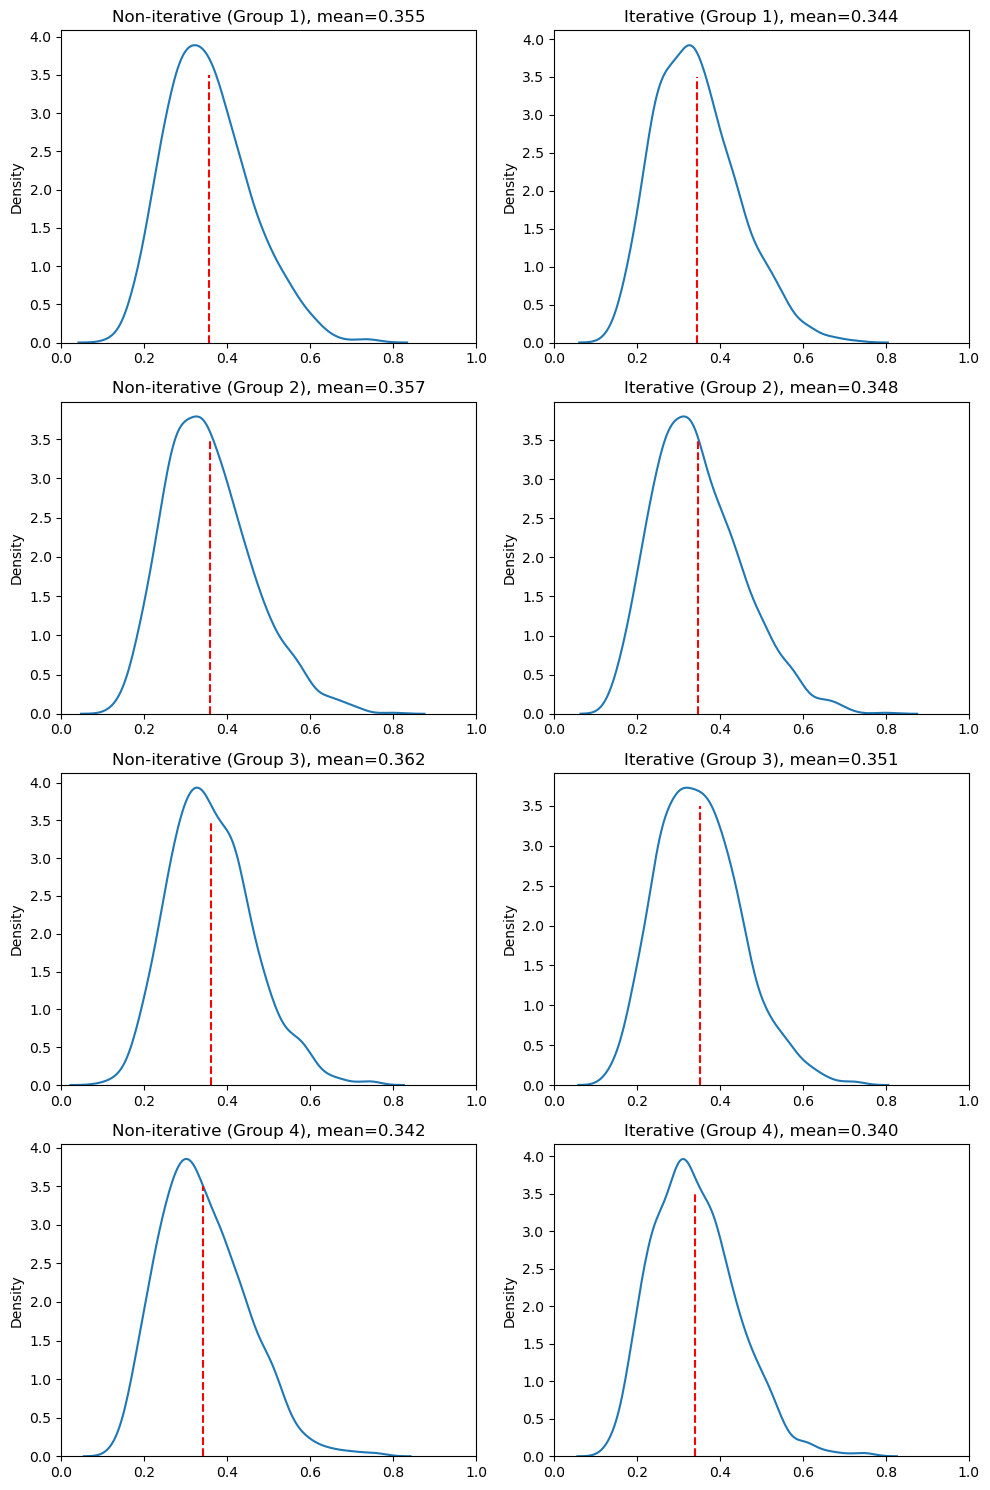

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

for i in range(4):
    # Load data
    predictions_noniterative = pd.read_csv(fr".\cross_val_data\predictions_noniterative_{i}.csv", index_col=0)
    predictions_iterative = pd.read_csv(fr".\cross_val_data\predictions_iterative_{i}.csv", index_col=0)
    true_data = pd.read_csv(fr".\cross_val_data\true_data_{i}.csv", index_col=0)

    # Initialize lists to hold Bray-Curtis distances for each group
    bc_noniterative = []
    bc_iterative = []

    # Loop through each baboon
    for baboon in groups[i].keys():
        score_noniter =[] 
        score_iter =[]
        for idx in np.intersect1d(true_data.index, groups[i][baboon].metadata_I.index):
            
            # Calculate Bray-Curtis scores
            score_noniter.append(braycurtis(true_data.loc[idx], predictions_noniterative.loc[idx]))
            score_iter.append(braycurtis(true_data.loc[idx], predictions_iterative.loc[idx]))

            # Append the scores to respective lists
        bc_noniterative.extend(score_noniter)
        bc_iterative.extend(score_iter)

    # Plot KDE plots for both noniterative and iterative scores
    sns.kdeplot(bc_noniterative, ax=axes[i, 0], label="noniterative")
    sns.kdeplot(bc_iterative, ax=axes[i, 1], label="iterative")
    axes[i, 0].set_xlim(0, 1)
    axes[i, 1].set_xlim(0, 1)
    axes[i, 0].vlines(np.mean(bc_noniterative), 0, 3.5, color='red', linestyle='--')
    axes[i, 1].vlines(np.mean(bc_iterative), 0, 3.5, color='red', linestyle='--')

    # Set titles
    axes[i, 0].set_title(f"Non-iterative (Group {i+1}), mean={np.mean(bc_noniterative):.3f}")
    axes[i, 1].set_title(f"Iterative (Group {i+1}), mean={np.mean(bc_iterative):.3f}")

plt.tight_layout()
plt.show()

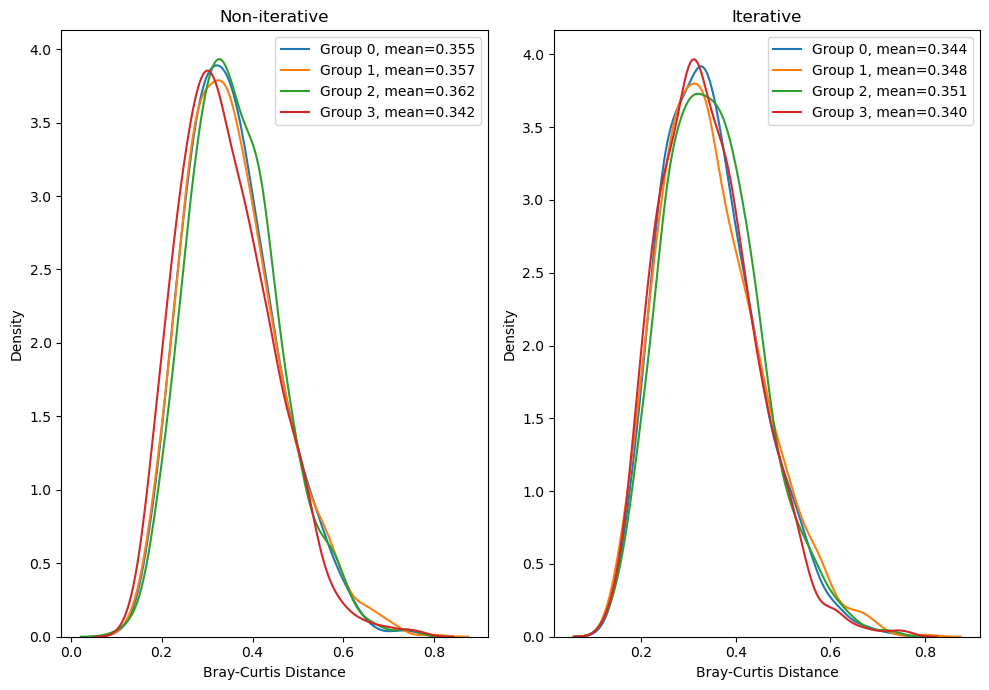

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))
        
for i in range(4):
    # Load data
    predictions_noniterative = pd.read_csv(fr".\cross_val_data\predictions_noniterative_{i}.csv", index_col=0)
    predictions_iterative = pd.read_csv(fr".\cross_val_data\predictions_iterative_{i}.csv", index_col=0)
    true_data = pd.read_csv(fr".\cross_val_data\true_data_{i}.csv", index_col=0)

    # Initialize lists to hold Bray-Curtis distances for each group
    bc_noniterative = []
    bc_iterative = []

    # Loop through each baboon
    for baboon in groups[i].keys():
        score_noniter =[] 
        score_iter =[]
        for idx in np.intersect1d(true_data.index, groups[i][baboon].metadata_I.index):
            
            # Calculate Bray-Curtis scores
            score_noniter.append(braycurtis(true_data.loc[idx], predictions_noniterative.loc[idx]))
            score_iter.append(braycurtis(true_data.loc[idx], predictions_iterative.loc[idx]))

            # Append the scores to respective lists
        bc_noniterative.extend(score_noniter)
        bc_iterative.extend(score_iter)


    # Plot KDE for non-iterative and iterative results across group
    sns.kdeplot(bc_noniterative, ax=axes[0], label=f"Group {i}, mean={np.mean(bc_noniterative):.3f}")
    sns.kdeplot(bc_iterative, ax=axes[1],  label=f"Group {i}, mean={np.mean(bc_iterative):.3f}")

# Set titles and labels
axes[0].set_title("Non-iterative")
axes[1].set_title("Iterative")
axes[0].set_xlabel("Bray-Curtis Distance")
axes[1].set_xlabel("Bray-Curtis Distance")
axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()

### Only first 2

In [8]:

baboons = model.baboons
dict_list = list(model.baboons.items())
np.random.shuffle(dict_list)
groups = [dict(group) for group in np.array_split(dict_list,4)]

data_df = pd.read_csv(data_path, index_col=0)
metadata_df = pd.read_csv(metadata_path, index_col=0)

for i in range(4):
    train_metatdata = metadata_df[~metadata_df["baboon_id"].isin(groups[i].keys())]
    train_data = data_df.loc[train_metatdata.index]
    known_metadata = metadata_df[metadata_df['baboon_id'].isin(groups[i].keys())]
    indicies = []
    for baboon in groups[i].values():
        indicies.extend(baboon.metadata_I.index[:2])

    known_data = data_df.loc[indicies]
    true_data = data_df.loc[known_metadata[~np.isin(known_metadata.index, indicies)].index]


    train_data.to_csv(fr".\cross_val_data\train_data_{i}.csv")
    train_metatdata.to_csv(fr".\cross_val_data\train_metadata_{i}.csv")
    known_data.to_csv(fr".\cross_val_data\known_data_{i}.csv")
    known_metadata.to_csv(fr".\cross_val_data\known_metadata_{i}.csv")
    true_data.to_csv(fr".\cross_val_data\true_data_{i}.csv")
    

In [10]:
baboons = model.baboons
dict_list = list(model.baboons.items())
np.random.shuffle(dict_list)
groups = [dict(group) for group in np.array_split(dict_list,4)]
metadata_df, data_df = social_model_class_v2_cos.preprocessing(data_path, metadata_path)

for i in range(4):
    train_metatdata = metadata_df[~metadata_df["baboon_id"].isin(groups[i].keys())]
    train_data = data_df.loc[train_metatdata.index]
    known_metadata = metadata_df[metadata_df['baboon_id'].isin(groups[i].keys())]
    indicies = []
    for baboon in groups[i].values():
        indicies.extend(baboon.metadata_I.index[:2])

    known_data = data_df.loc[indicies]
    true_data = data_df.loc[known_metadata[~np.isin(known_metadata.index, indicies)].index]


    train_data.to_csv(fr".\cross_val_data\train_data_{i}.csv")
    train_metatdata.to_csv(fr".\cross_val_data\train_metadata_{i}.csv")
    known_data.to_csv(fr".\cross_val_data\known_data_{i}.csv")
    known_metadata.to_csv(fr".\cross_val_data\known_metadata_{i}.csv")
    true_data.to_csv(fr".\cross_val_data\true_data_{i}.csv")
    
for i in range(4):
    model = social_model_class_v2_cos.superModel(fr".\cross_val_data\train_data_{i}.csv", fr".\cross_val_data\train_metadata_{i}.csv")
    model.alpha_ = np.array([0]*61)
    
    cpus = max(1, min(multiprocessing.cpu_count() - 2, len(model.baboons)))
    with ProcessPoolExecutor(cpus) as executor:
    
        future_to_baboon = {executor.submit(baboon.fit, model.alpha_, 0): baboon for baboon in model.baboons.values()}
    
    for future in as_completed(future_to_baboon):
        baboon = future_to_baboon[future]  # Get the baboon that corresponds to this future
        baboon.beta_ = future.result()[0]  # Get the result of the computation
        
    # for baboon in model.baboons.values():
    #     baboon.beta_= np.random.rand(61)
    
    print(f"predicting {i}")
    
    model.add_new_data(fr".\cross_val_data\known_data_{i}.csv", fr".\cross_val_data\known_metadata_{i}.csv")

    print(f"new data added {i}")
    predictions_noniterative = model.predict(groups[i].keys(), iterative=False)
    predictions_iterative = model.predict(groups[i].keys(), iterative=True)
    predictions_noniterative.to_csv(fr".\cross_val_data\predictions_noniterative_{i}.csv")
    predictions_iterative.to_csv(fr".\cross_val_data\predictions_iterative_{i}.csv")

/home/jupyter-tomeroron/baboons/social_model_class_v2_cos.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_clean['collection_date'] = pd.to_datetime(metadata_clean['collection_date'])


predicting 0
new data added 0
predicting 1
new data added 1
predicting 2
new data added 2
predicting 3
new data added 3


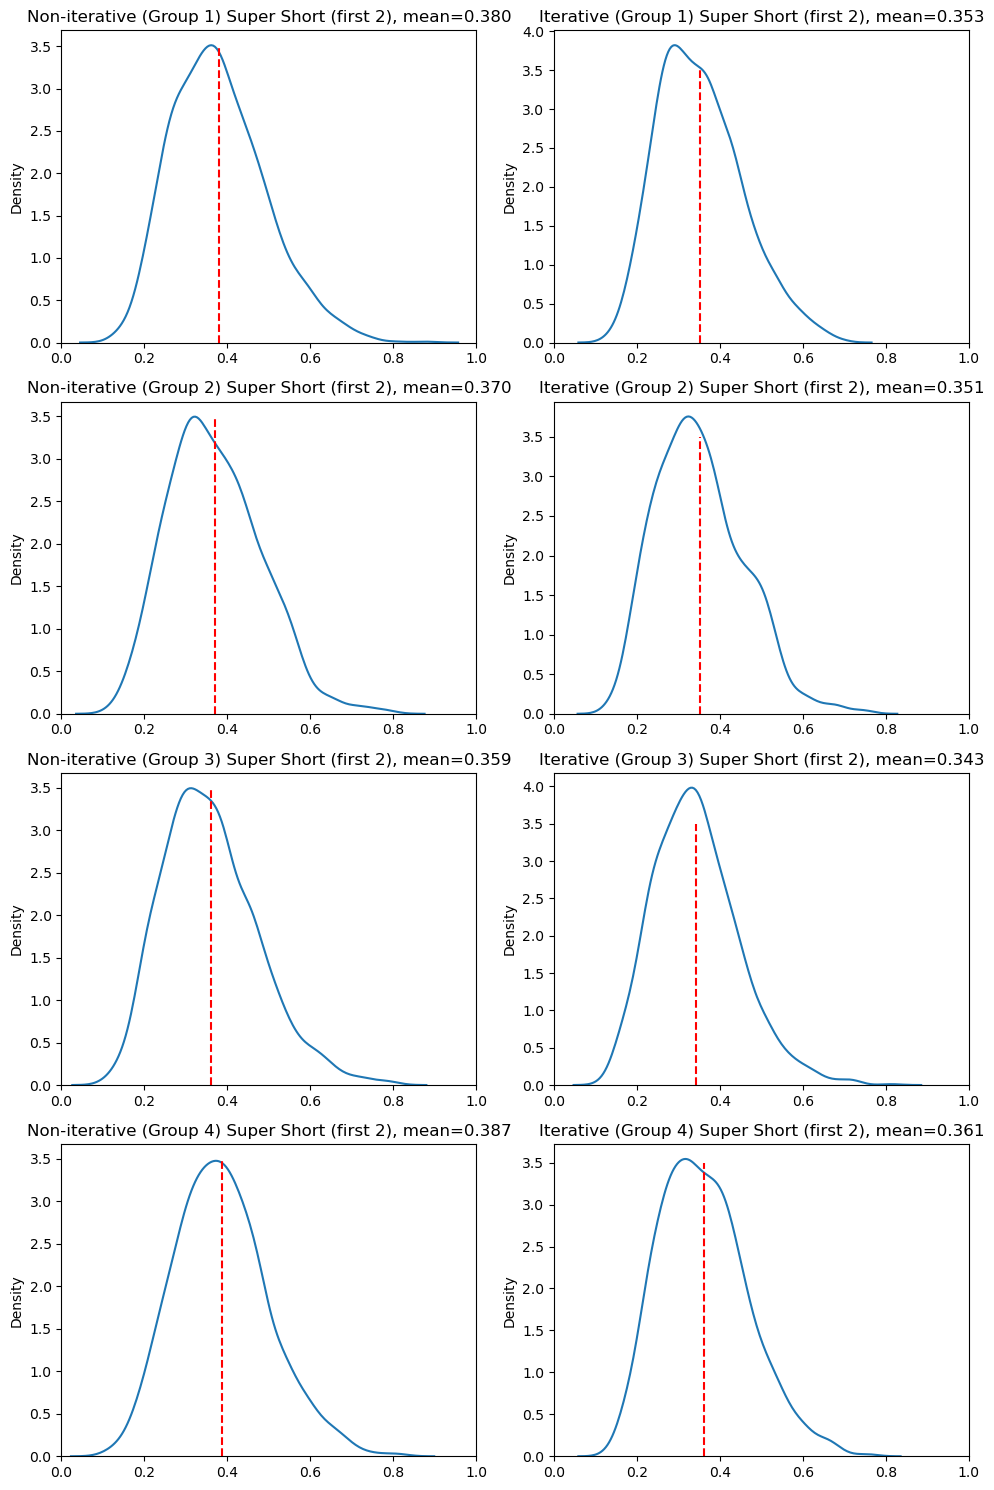

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

for i in range(4):
    # Load data
    predictions_noniterative = pd.read_csv(fr".\cross_val_data\predictions_noniterative_{i}.csv", index_col=0)
    predictions_iterative = pd.read_csv(fr".\cross_val_data\predictions_iterative_{i}.csv", index_col=0)
    true_data = pd.read_csv(fr".\cross_val_data\true_data_{i}.csv", index_col=0)

    # Initialize lists to hold Bray-Curtis distances for each group
    bc_noniterative = []
    bc_iterative = []

    # Loop through each baboon
    for baboon in groups[i].keys():
        score_noniter =[] 
        score_iter =[]
        for idx in np.intersect1d(true_data.index, groups[i][baboon].metadata_I.index):
            
            # Calculate Bray-Curtis scores
            score_noniter.append(braycurtis(true_data.loc[idx], predictions_noniterative.loc[idx]))
            score_iter.append(braycurtis(true_data.loc[idx], predictions_iterative.loc[idx]))

            # Append the scores to respective lists
        bc_noniterative.extend(score_noniter)
        bc_iterative.extend(score_iter)


    # Plot KDE for non-iterative and iterative results across group
    sns.kdeplot(bc_noniterative, ax=axes[i, 0], label="noniterative")
    sns.kdeplot(bc_iterative, ax=axes[i, 1], label="iterative")
    axes[i, 0].set_xlim(0, 1)
    axes[i, 1].set_xlim(0, 1)
    axes[i, 0].vlines(np.mean(bc_noniterative), 0, 3.5, color='red', linestyle='--')
    axes[i, 1].vlines(np.mean(bc_iterative), 0, 3.5, color='red', linestyle='--')

    # Set titles
    axes[i, 0].set_title(f"Non-iterative (Group {i+1}) Super Short (first 2), mean={np.mean(bc_noniterative):.3f}")
    axes[i, 1].set_title(f"Iterative (Group {i+1}) Super Short (first 2), mean={np.mean(bc_iterative):.3f}")

plt.tight_layout()
plt.show()

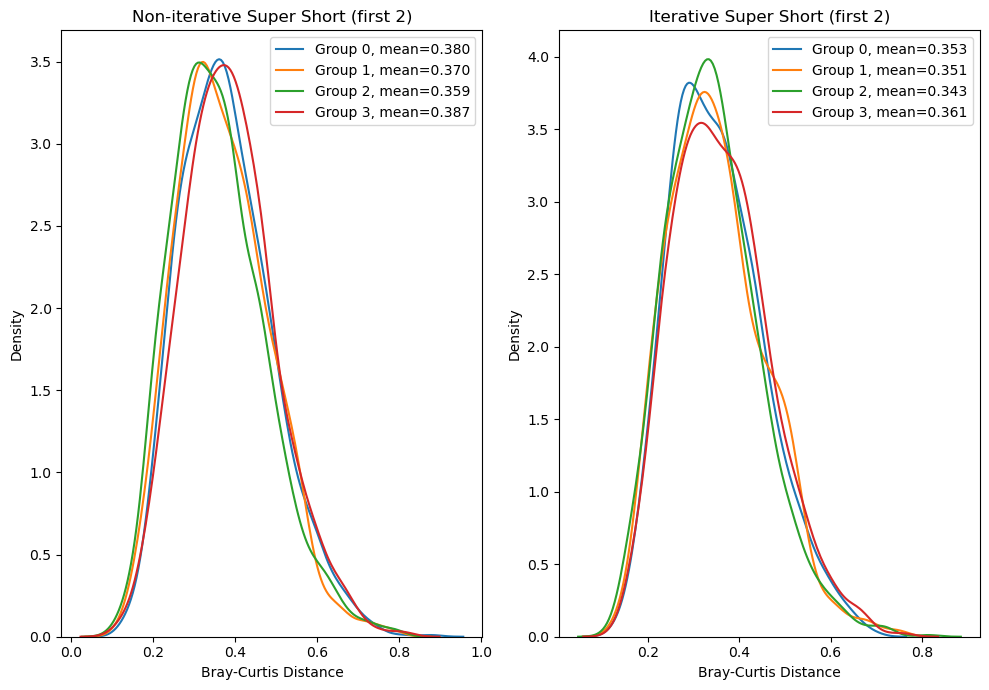

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))

# Initialize lists to accumulate Bray-Curtis distances for all groups
bc_noniterative = []
bc_iterative = []

for i in range(4):
    # Load data
    predictions_noniterative = pd.read_csv(fr".\cross_val_data\predictions_noniterative_{i}.csv", index_col=0)
    predictions_iterative = pd.read_csv(fr".\cross_val_data\predictions_iterative_{i}.csv", index_col=0)
    true_data = pd.read_csv(fr".\cross_val_data\true_data_{i}.csv", index_col=0)

    # Initialize lists to hold Bray-Curtis distances for each group
    bc_noniterative = []
    bc_iterative = []

    # Loop through each baboon
    for baboon in groups[i].keys():
        score_noniter =[] 
        score_iter =[]
        for idx in np.intersect1d(true_data.index, groups[i][baboon].metadata_I.index):
            
            # Calculate Bray-Curtis scores
            score_noniter.append(braycurtis(true_data.loc[idx], predictions_noniterative.loc[idx]))
            score_iter.append(braycurtis(true_data.loc[idx], predictions_iterative.loc[idx]))

            # Append the scores to respective lists
        bc_noniterative.extend(score_noniter)
        bc_iterative.extend(score_iter)


    # Plot KDE for non-iterative and iterative results across group
    sns.kdeplot(bc_noniterative, ax=axes[0], label=f"Group {i}, mean={np.mean(bc_noniterative):.3f}")
    sns.kdeplot(bc_iterative, ax=axes[1],  label=f"Group {i}, mean={np.mean(bc_iterative):.3f}")

# Set titles and labels
axes[0].set_title("Non-iterative Super Short (first 2)")
axes[1].set_title("Iterative Super Short (first 2)")
axes[0].set_xlabel("Bray-Curtis Distance")
axes[1].set_xlabel("Bray-Curtis Distance")
axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()

### all but last 10

In [13]:

baboons = model.baboons
dict_list = list(model.baboons.items())
np.random.shuffle(dict_list)
groups = [dict(group) for group in np.array_split(dict_list,4)]

data_df = pd.read_csv(data_path, index_col=0)
metadata_df = pd.read_csv(metadata_path, index_col=0)

for i in range(4):
    train_metatdata = metadata_df[~metadata_df["baboon_id"].isin(groups[i].keys())]
    train_data = data_df.loc[train_metatdata.index]
    known_metadata = metadata_df[metadata_df['baboon_id'].isin(groups[i].keys())]
    indicies = []
    for baboon in groups[i].values():
        indicies.extend(baboon.metadata_I.index[:-10])

    known_data = data_df.loc[indicies]
    true_data = data_df.loc[known_metadata[~np.isin(known_metadata.index, indicies)].index]


    train_data.to_csv(fr".\cross_val_data\train_data_{i}.csv")
    train_metatdata.to_csv(fr".\cross_val_data\train_metadata_{i}.csv")
    known_data.to_csv(fr".\cross_val_data\known_data_{i}.csv")
    known_metadata.to_csv(fr".\cross_val_data\known_metadata_{i}.csv")
    true_data.to_csv(fr".\cross_val_data\true_data_{i}.csv")
    

In [17]:

baboons = model.baboons
dict_list = list(model.baboons.items())
np.random.shuffle(dict_list)
groups = [dict(group) for group in np.array_split(dict_list,4)]
metadata_df, data_df = social_model_class_v2_cos.preprocessing(data_path, metadata_path)

for i in range(4):
    train_metatdata = metadata_df[~metadata_df["baboon_id"].isin(groups[i].keys())]
    train_data = data_df.loc[train_metatdata.index]
    known_metadata = metadata_df[metadata_df['baboon_id'].isin(groups[i].keys())]
    indicies = []
    for baboon in groups[i].values():
        indicies.extend(baboon.metadata_I.index[:-10])

    known_data = data_df.loc[indicies]
    true_data = data_df.loc[known_metadata[~np.isin(known_metadata.index, indicies)].index]


    train_data.to_csv(fr".\cross_val_data\train_data_{i}.csv")
    train_metatdata.to_csv(fr".\cross_val_data\train_metadata_{i}.csv")
    known_data.to_csv(fr".\cross_val_data\known_data_{i}.csv")
    known_metadata.to_csv(fr".\cross_val_data\known_metadata_{i}.csv")
    true_data.to_csv(fr".\cross_val_data\true_data_{i}.csv")
    
for i in range(4):
    model = social_model_class_v2_cos.superModel(fr".\cross_val_data\train_data_{i}.csv", fr".\cross_val_data\train_metadata_{i}.csv")
    model.alpha_ = np.array([0]*61)
    
    cpus = max(1, min(multiprocessing.cpu_count() - 2, len(model.baboons)))
    with ProcessPoolExecutor(cpus) as executor:
    
        future_to_baboon = {executor.submit(baboon.fit, model.alpha_, model.gamma_): baboon for baboon in model.baboons.values()}
    
    for future in as_completed(future_to_baboon):
        baboon = future_to_baboon[future]  # Get the baboon that corresponds to this future
        baboon.beta_ = future.result()[0]  # Get the result of the computation
    # for baboon in model.baboons.values():
    #     baboon.beta_= np.random.rand(61)
    
    print(f"predicting {i}")
    
    model.add_new_data(fr".\cross_val_data\known_data_{i}.csv", fr".\cross_val_data\known_metadata_{i}.csv")

    print(f"new data added {i}")
    predictions_noniterative = model.predict(groups[i].keys(), iterative=False)
    predictions_iterative = model.predict(groups[i].keys(), iterative=True)
    predictions_noniterative.to_csv(fr".\cross_val_data\predictions_noniterative_{i}.csv")
    predictions_iterative.to_csv(fr".\cross_val_data\predictions_iterative_{i}.csv")

/home/jupyter-tomeroron/baboons/social_model_class_v2_cos.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_clean['collection_date'] = pd.to_datetime(metadata_clean['collection_date'])


predicting 0
new data added 0
predicting 1
new data added 1
predicting 2
new data added 2
predicting 3
new data added 3


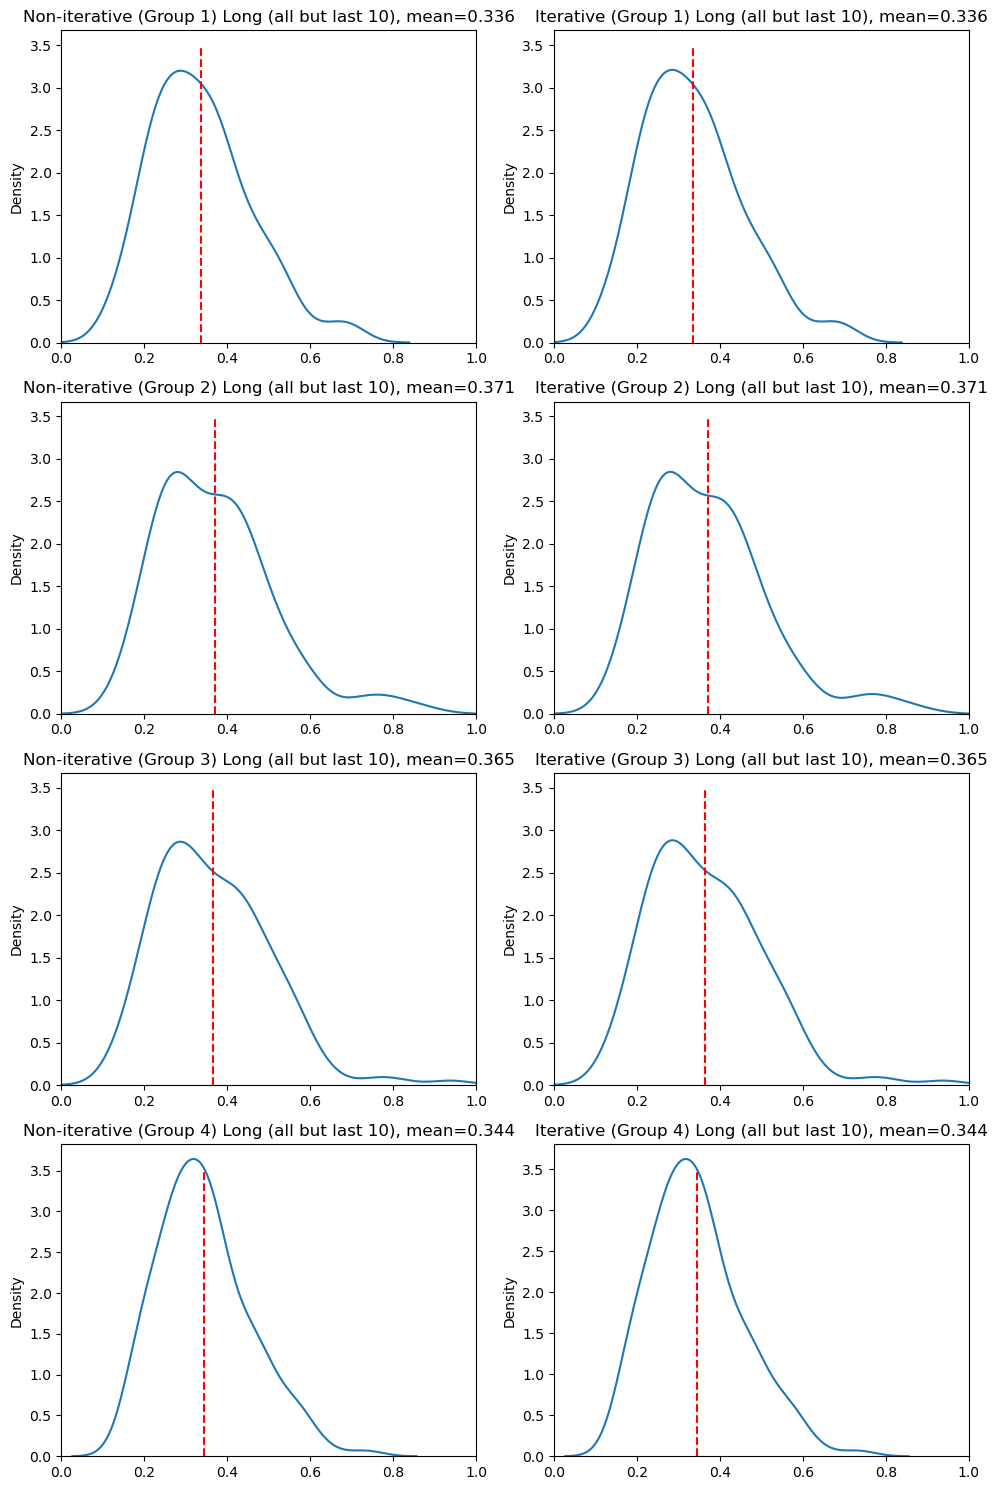

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

for i in range(4):
    # Load data
    predictions_noniterative = pd.read_csv(fr".\cross_val_data\predictions_noniterative_{i}.csv", index_col=0)
    predictions_iterative = pd.read_csv(fr".\cross_val_data\predictions_iterative_{i}.csv", index_col=0)
    true_data = pd.read_csv(fr".\cross_val_data\true_data_{i}.csv", index_col=0)

    # Initialize lists to hold Bray-Curtis distances for each group
    bc_noniterative = []
    bc_iterative = []

    # Loop through each baboon
    for baboon in groups[i].keys():
        score_noniter =[] 
        score_iter =[]
        for idx in np.intersect1d(true_data.index, groups[i][baboon].metadata_I.index):
            
            # Calculate Bray-Curtis scores
            score_noniter.append(braycurtis(true_data.loc[idx], predictions_noniterative.loc[idx]))
            score_iter.append(braycurtis(true_data.loc[idx], predictions_iterative.loc[idx]))

            # Append the scores to respective lists
        bc_noniterative.extend(score_noniter)
        bc_iterative.extend(score_iter)


    # Plot KDE for non-iterative and iterative results across group
    sns.kdeplot(bc_noniterative, ax=axes[i, 0], label="noniterative")
    sns.kdeplot(bc_iterative, ax=axes[i, 1], label="iterative")
    axes[i, 0].set_xlim(0, 1)
    axes[i, 1].set_xlim(0, 1)
    axes[i, 0].vlines(np.mean(bc_noniterative), 0, 3.5, color='red', linestyle='--')
    axes[i, 1].vlines(np.mean(bc_iterative), 0, 3.5, color='red', linestyle='--')

    # Set titles
    axes[i, 0].set_title(f"Non-iterative (Group {i+1}) Long (all but last 10), mean={np.mean(bc_noniterative):.3f}")
    axes[i, 1].set_title(f"Iterative (Group {i+1}) Long (all but last 10), mean={np.mean(bc_iterative):.3f}")

plt.tight_layout()
plt.show()

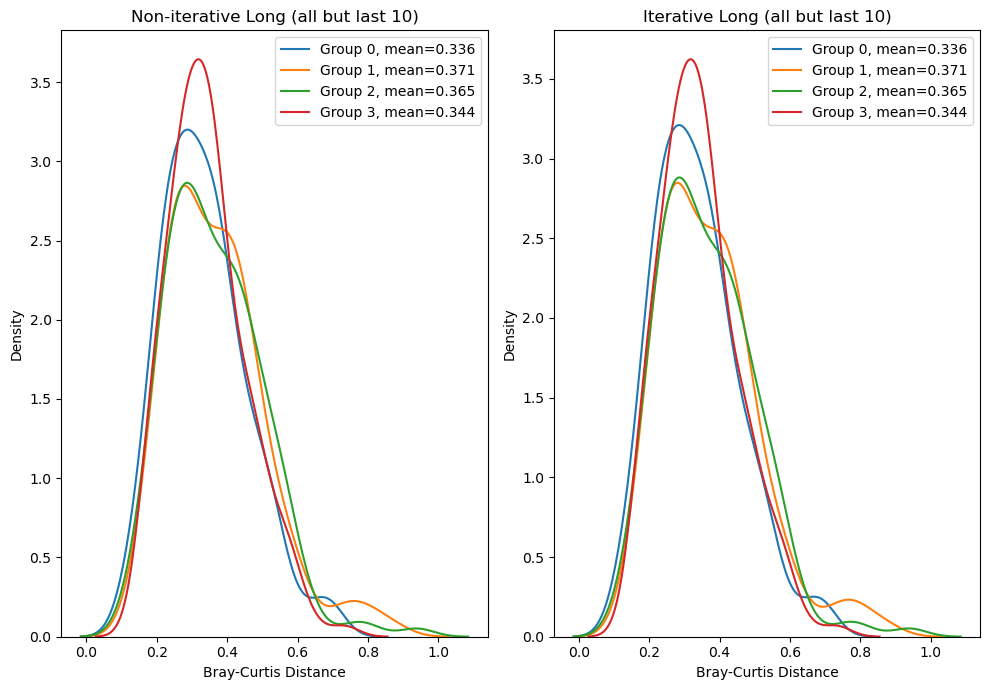

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))

for i in range(4):
    # Load data
    predictions_noniterative = pd.read_csv(fr".\cross_val_data\predictions_noniterative_{i}.csv", index_col=0)
    predictions_iterative = pd.read_csv(fr".\cross_val_data\predictions_iterative_{i}.csv", index_col=0)
    true_data = pd.read_csv(fr".\cross_val_data\true_data_{i}.csv", index_col=0)

    # Initialize lists to hold Bray-Curtis distances for each group
    bc_noniterative = []
    bc_iterative = []

    # Loop through each baboon
    for baboon in groups[i].keys():
        score_noniter =[] 
        score_iter =[]
        for idx in np.intersect1d(true_data.index, groups[i][baboon].metadata_I.index):
            
            # Calculate Bray-Curtis scores
            score_noniter.append(braycurtis(true_data.loc[idx], predictions_noniterative.loc[idx]))
            score_iter.append(braycurtis(true_data.loc[idx], predictions_iterative.loc[idx]))

            # Append the scores to respective lists
        bc_noniterative.extend(score_noniter)
        bc_iterative.extend(score_iter)


    # Plot KDE for non-iterative and iterative results across group
    sns.kdeplot(bc_noniterative, ax=axes[0], label=f"Group {i}, mean={np.mean(bc_noniterative):.3f}")
    sns.kdeplot(bc_iterative, ax=axes[1],  label=f"Group {i}, mean={np.mean(bc_iterative):.3f}")

# Set titles and labels
axes[0].set_title("Non-iterative Long (all but last 10)")
axes[1].set_title("Iterative Long (all but last 10)")
axes[0].set_xlabel("Bray-Curtis Distance")
axes[1].set_xlabel("Bray-Curtis Distance")
axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()